In [1]:
# import ibm_db
# import ibm_db_dbi

In [2]:
# dsn_hostname = "dal09anadbd1.na.ibm.net" # e.g.: "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
# dsn_uid = "#######" # e.g. "abc12345"
# dsn_pwd = "############" # e.g. "7dBZ3wWt9XN6$o0J"
# dsn_driver = "{IBM DB2 ODBC DRIVER}"
# dsn_database = "POCDB"            # e.g. "BLUDB"
# dsn_port = "60002"                # e.g. "50000" 
# dsn_protocol = "TCPIP"

In [3]:
# dsn = (
#     "DRIVER={0};"
#     "DATABASE={1};"
#     "HOSTNAME={2};"
#     "PORT={3};"
#     "PROTOCOL={4};"
#     "UID={5};"
#     "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol,dsn_uid, dsn_pwd)

In [4]:
# try:
#     conn = ibm_db.pconnect(dsn, "", "")
#     print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

# except:
#     print ("Unable to connect: ", ibm_db.conn_errormsg() )
    
# ibm_db.close(conn)



# from ibmdbpy import IdaDataBase, IdaDataFrame
# pconn = ibm_db_dbi.Connection(conn)


In [5]:

import time 
import random 
import datetime
from datetime import date
import pandas as pd 
import matplotlib.pyplot as plt 
import statistics 
import numpy as np 
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
from IPython.display import Image
from scipy.stats import pointbiserialr
pd.options.display.float_format = '{:.2f}'.format
#setting dimensions for plot
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
ar_AR_sample=pd.read_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/AVENT.AR_REGRESSION.csv",index_col=0)

C:\Users\YogeshGovindan\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
#creating copy
ar_data=ar_AR_sample.copy()

In [8]:
ar_data.columns

Index(['DOCUMENTNO', 'ITEMNO', 'CUSTOMER', 'COMPCODE', 'PAY_TERM', 'DOC_TYPE',
       'DOC_DATE', 'POSTINGDATE', 'NETDUEDATE', 'CLEARINGDA', 'AGING',
       'AGING_BUCKET', 'PAYMENT_FLAG', 'AMOUNT', 'SEG_NUM_OVERDUE_INVOICES',
       'SEG_NUM_OPEN_INVOICES', 'SEG_DDSO', 'SEG_DSO', 'SEG_AVERAGE_DAYS_LATE',
       'SEG_RISK_DEFAULT_VAL', 'SEG_RISK_DEFAULT', 'SEG_PRIORITY_VAL',
       'SEG_PRIORITY', 'SEG_PROP_PAY_VAL', 'SEG_PROP_PAY'],
      dtype='object')

In [9]:
# relative frequency of the missings per column
#missing=pd.DataFrame(ar_data.isna().sum()/(len(ar_data))*100)

In [10]:
#missing

In [11]:
#dropping unwanted columns and Missing columns
col=['SEG_RISK_DEFAULT','SEG_PROP_PAY_VAL','ITEMNO']
ar_data=ar_data.drop(columns=col,axis=1)

In [12]:
ar_data['DOC_DATE']=pd.to_datetime(ar_data['DOC_DATE'])
ar_data['POSTINGDATE']=pd.to_datetime(ar_data['POSTINGDATE'])
ar_data['NETDUEDATE']=pd.to_datetime(ar_data['NETDUEDATE'])
ar_data['CLEARINGDA']=pd.to_datetime(ar_data['CLEARINGDA'])

In [13]:
ar_data['cleardate_year']=pd.DatetimeIndex(ar_data['CLEARINGDA']).year
ar_data['doc_date_year']=pd.DatetimeIndex(ar_data['DOC_DATE']).year

In [14]:
ar_data['Invoice_cycle']=ar_data['CLEARINGDA']-ar_data['DOC_DATE']

In [15]:
ar_data['Invoice_cycle'] = ar_data['Invoice_cycle'].dt.days.astype('int16')

In [16]:
ar_data['Invoice_cycle'].mean()

69.62044337850979

In [17]:
ar_data['NETDUEDATE_year']=pd.DatetimeIndex(ar_data['NETDUEDATE']).year

In [18]:
ar_data['NETDUEDATE_year'].value_counts().sort_index()

2016        374
2017       5001
2018     362465
2019    1470343
2020     969092
2021       2153
Name: NETDUEDATE_year, dtype: int64

In [19]:
ar_data.groupby('NETDUEDATE_year')['AGING'].sum()/ar_data['AGING'].sum()

NETDUEDATE_year
2016   -0.05
2017   -0.43
2018   -0.34
2019    1.04
2020    0.75
2021    0.03
Name: AGING, dtype: float64

# AGING

In [20]:
ar_data.groupby('AGING_BUCKET')['AMOUNT'].sum()/ar_data['AMOUNT'].sum()

AGING_BUCKET
A_6 AND BEFORE DAYS    0.29
B_0 TO 5 BEFORE DAYS   0.19
C_1 TO 5 DAYS          0.22
D_6 TO 10 DAYS         0.12
E_11 TO 30 DAYS        0.13
F_31 TO 60 DAYS        0.03
G_61 TO 90 DAYS        0.01
H_>90 DAYS             0.01
Name: AMOUNT, dtype: float64

In [21]:
ar_data['PAYMENT_FLAG'].value_counts(normalize=True) 

EARLY    0.53
LATE     0.41
ONTIME   0.06
Name: PAYMENT_FLAG, dtype: float64

# Creating Amount Bucket

In [22]:
ar_data['Amount_qcut']=pd.qcut(ar_data['AMOUNT'],q=[-1,0.25,0.75,1])

In [23]:
ar_data['Amount_qcut'].value_counts()

(61.5, 1200.0]          1405700
(-4800000.001, 61.5]     702358
(1200.0, 21720086.0]     701369
Name: Amount_qcut, dtype: int64

In [24]:
def Amntbucket(AMOUNT):
    if AMOUNT<=61.5:
        return 'Low_value'
    elif AMOUNT>61.5and AMOUNT<=1200.0:
        return 'Medium'
    else: return 'High_value'

In [25]:
ar_data['AMOUNT_BUCKET']=ar_data.apply(lambda x:Amntbucket(x['AMOUNT']),axis=1)

In [26]:
ar_data['AMOUNT_BUCKET'].value_counts(normalize=True)

Medium       0.50
Low_value    0.25
High_value   0.25
Name: AMOUNT_BUCKET, dtype: float64

In [27]:
ar_new=ar_data # creating a copy of the data

In [28]:
cust_summary = ar_new.groupby('CUSTOMER') \
       .agg({'DOCUMENTNO':'size', 'AMOUNT':'mean','AGING':'mean','Invoice_cycle':'mean'}) \
       .rename(columns={'DOCUMENTNO':'DOCUMENTNO_COUNT','AMOUNT':'AMOUNT_AVG','AGING':'AGING_AVG','Invoice_cycle':'Invoice_cycle_AVG'}) \
       .reset_index()

In [29]:
AR_data_merg=pd.merge(ar_new,cust_summary,on='CUSTOMER',how='left')

In [30]:
#droppns and Missing columns
col1=['DOCUMENTNO','AGING_BUCKET','PAYMENT_FLAG','CUSTOMER','AMOUNT','COMPCODE','DOC_TYPE','DOC_DATE','POSTINGDATE','NETDUEDATE','CLEARINGDA','cleardate_year','doc_date_year','SEG_PRIORITY','Amount_qcut']
AR_data_merg1=AR_data_merg.drop(columns=col1,axis=1)

In [31]:
#Correlation
AR_data_merg1_select1=AR_data_merg1.select_dtypes(exclude=[object])
correlation=AR_data_merg1.corr()
round(correlation,3)

,AGING,SEG_NUM_OVERDUE_INVOICES,SEG_NUM_OPEN_INVOICES,SEG_DDSO,SEG_DSO,SEG_AVERAGE_DAYS_LATE,SEG_RISK_DEFAULT_VAL,SEG_PRIORITY_VAL,Invoice_cycle,NETDUEDATE_year,DOCUMENTNO_COUNT,AMOUNT_AVG,AGING_AVG,Invoice_cycle_AVG
AGING,1.00,0.02,-0.01,0.04,0.04,0.41,0.16,0.03,0.73,-0.17,0.00,0.01,0.50,0.20
SEG_NUM_OVERDUE_INVOICES,0.02,1.00,0.84,-0.01,0.01,0.02,-0.01,0.56,0.37,-0.04,0.80,-0.07,0.05,0.52
SEG_NUM_OPEN_INVOICES,-0.01,0.84,1.00,-0.01,0.01,-0.07,-0.18,0.52,0.41,-0.04,0.88,-0.08,-0.01,0.57
SEG_DDSO,0.04,-0.01,-0.01,1.00,1.00,0.13,0.20,0.01,0.03,-0.02,-0.01,-0.00,0.08,0.04
SEG_DSO,0.04,0.01,0.01,1.00,1.00,0.14,0.20,0.03,0.06,-0.02,-0.00,-0.00,0.08,0.08
SEG_AVERAGE_DAYS_LATE,0.41,0.02,-0.07,0.13,0.14,1.00,0.35,0.06,0.22,-0.05,-0.07,0.03,0.93,0.31
SEG_RISK_DEFAULT_VAL,0.16,-0.01,-0.18,0.20,0.20,0.35,1.00,0.10,0.03,-0.03,-0.19,0.01,0.35,0.05
SEG_PRIORITY_VAL,0.03,0.56,0.52,0.01,0.03,0.06,0.10,1.00,0.30,-0.01,0.46,-0.03,0.07,0.43
Invoice_cycle,0.73,0.37,0.41,0.03,0.06,0.22,0.03,0.30,1.00,-0.14,0.27,-0.03,0.28,0.72
NETDUEDATE_year,-0.17,-0.04,-0.04,-0.02,-0.02,-0.05,-0.03,-0.01,-0.14,1.00,-0.05,0.01,-0.08,-0.05


In [32]:
# #Correlation Plot
# f = plt.figure(figsize=(15, 11))
# plt.matshow(AR_data_merg1_select1.corr(), fignum=f.number)
# plt.xticks(range(AR_data_merg1_select1.shape[1]), AR_data_merg1_select1.columns, fontsize=14, rotation=45)
# plt.yticks(range(AR_data_merg1_select1.shape[1]), AR_data_merg1_select1.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=10)
# plt.title('Correlation Matrix', fontsize=13);

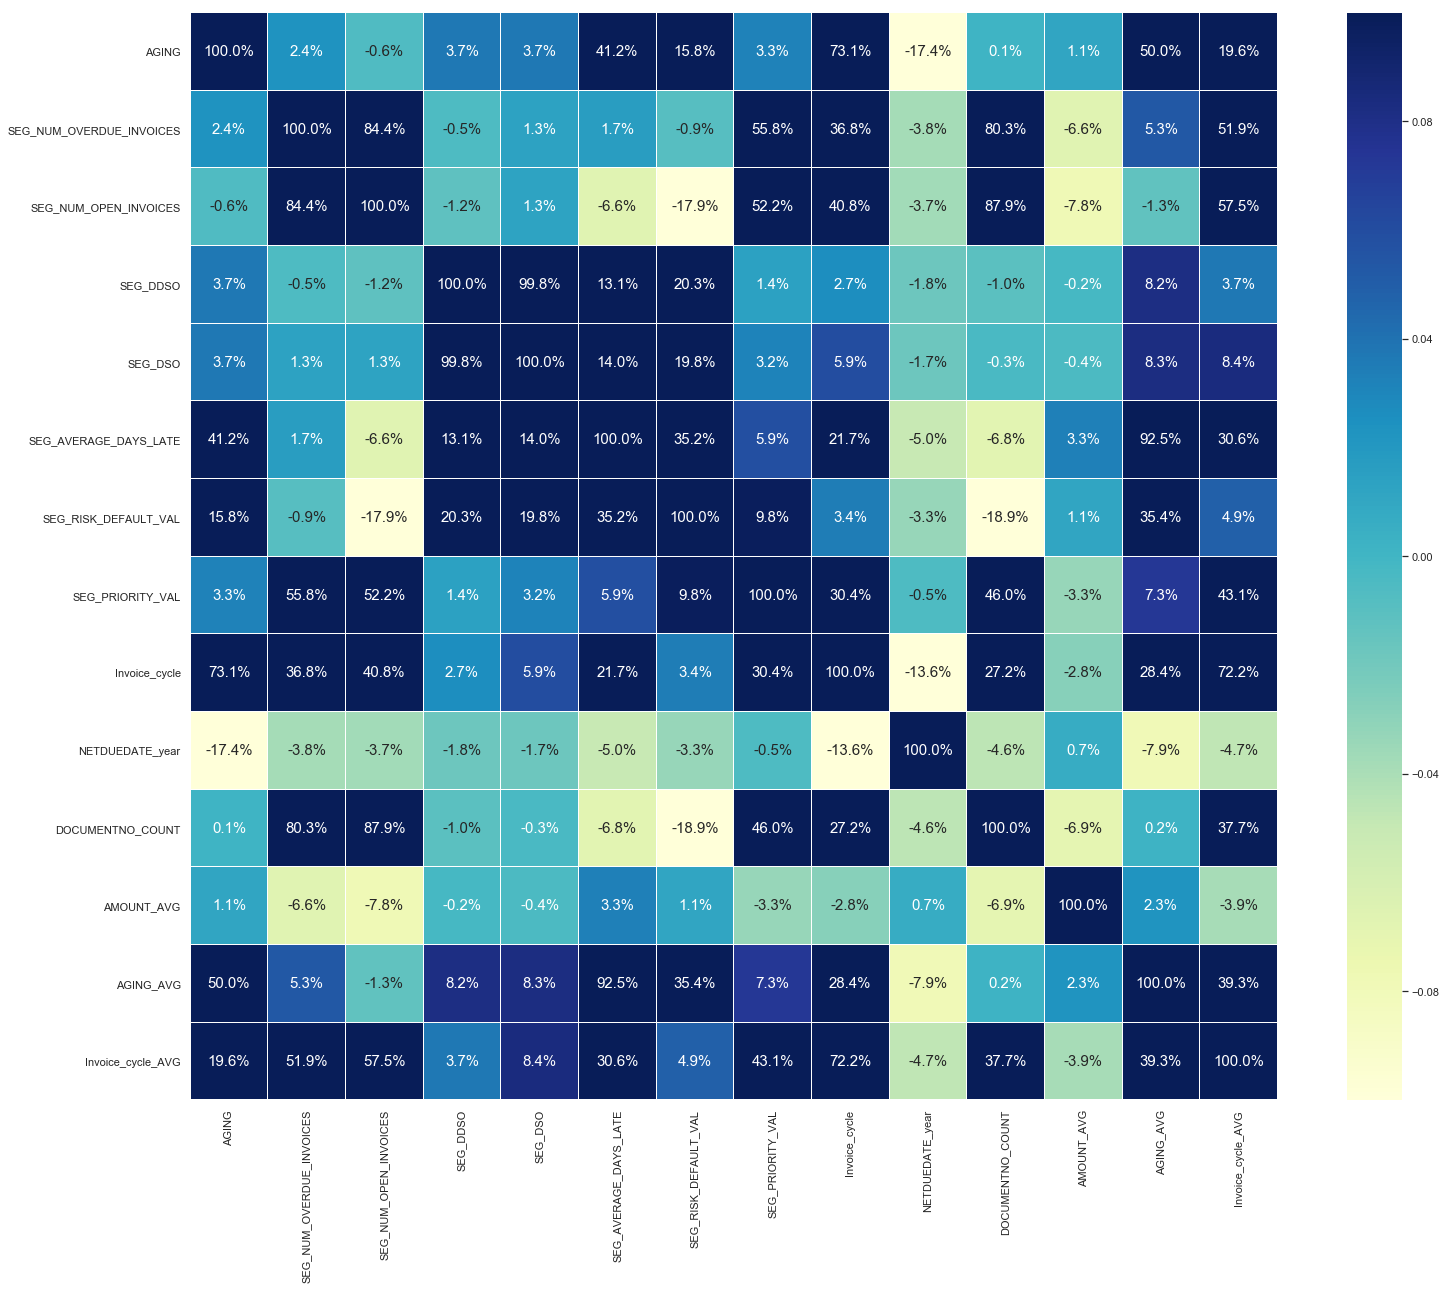

In [33]:
##Correlation Plot
plt.figure(figsize = (25, 20))
AR_corrplot=sns.heatmap(AR_data_merg1_select1.corr(),vmin=AR_data_merg1_select1.values.min(),vmax=1,square=True,
            linewidths=0.1,annot = True,fmt=".1%",annot_kws={"size":15},cmap="YlGnBu")
plt.show()
AR_corrplot.figure.savefig('C:/Users/YogeshGovindan/Desktop/AVNET/Model/Model_Image/corrplot_AR.png', bbox_inches='tight', pad_inches=0.0);

In [34]:
AR_data_merg1_select1.corr().loc[:,'AGING'].abs().sort_values(ascending=False)[1:]

Invoice_cycle              0.73
AGING_AVG                  0.50
SEG_AVERAGE_DAYS_LATE      0.41
Invoice_cycle_AVG          0.20
NETDUEDATE_year            0.17
SEG_RISK_DEFAULT_VAL       0.16
SEG_DSO                    0.04
SEG_DDSO                   0.04
SEG_PRIORITY_VAL           0.03
SEG_NUM_OVERDUE_INVOICES   0.02
AMOUNT_AVG                 0.01
SEG_NUM_OPEN_INVOICES      0.01
DOCUMENTNO_COUNT           0.00
Name: AGING, dtype: float64

In [35]:
##correlation between all columns and remove highly correlated ones using python or pandas
import numpy as np

# Create correlation matrix
corr_matrix = AR_data_merg1_select1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

In [36]:
to_drop

['SEG_NUM_OPEN_INVOICES', 'SEG_DSO', 'DOCUMENTNO_COUNT', 'AGING_AVG']

In [37]:
#dropping highly correlated independent variables
col2=['SEG_DDSO','Invoice_cycle_AVG','AMOUNT_AVG','AGING_AVG','DOCUMENTNO_COUNT','NETDUEDATE_year']
AR_omit=AR_data_merg1.drop(columns=col2,axis=1)

In [38]:
AR_omit_copy=AR_omit.copy()

In [39]:
AR_omit_copy.columns

Index(['PAY_TERM', 'AGING', 'SEG_NUM_OVERDUE_INVOICES',
       'SEG_NUM_OPEN_INVOICES', 'SEG_DSO', 'SEG_AVERAGE_DAYS_LATE',
       'SEG_RISK_DEFAULT_VAL', 'SEG_PRIORITY_VAL', 'SEG_PROP_PAY',
       'Invoice_cycle', 'AMOUNT_BUCKET'],
      dtype='object')

In [40]:
#Proportion of values as outlier in Aging
q75, q25 = np.percentile(AR_omit_copy['AGING'],[75 ,25]) 
iqr_aging = q75 - q25 

In [41]:
q75+3*iqr_aging # Upper limit cut

53.0

In [42]:
q25-1.5*iqr_aging # Upper limit cut

-35.0

# Importing Open data

In [43]:
open_raw=pd.read_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/ar_open_item_summary1.csv",index_col=0)

C:\Users\YogeshGovindan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
open_raw.shape

(276572, 68)

In [45]:
open_raw_no_disp=open_raw[open_raw['DISPUTE_FLAG']=='NO_DISPUTE']  ## NO dispute open data

In [46]:
open_raw_disp=open_raw[open_raw['DISPUTE_FLAG']=='DISPUTE']  ## dispute open data

In [47]:
open_raw_no_disp['AMOUNT'].sum()

719814068.1144545

In [48]:
open=pd.read_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/ar_open_reg1.csv",index_col=0) ## open regression table

In [49]:
# relative frequency of the missings per column
#missing=pd.DataFrame(open.isna().sum()/(len(open))*100)


In [50]:
#missing

In [51]:
open['CLEARINGDA'] = pd.Timestamp('2020-10-31')

In [52]:
open['PAY_TERM'].nunique()

143

In [53]:
open['DOC_DATE']=pd.to_datetime(open['DOC_DATE'])
open['POSTINGDATE']=pd.to_datetime(open['POSTINGDATE'])
open['NETDUEDATE']=pd.to_datetime(open['NETDUEDATE'])

In [54]:
open['NETDUEDATE_year']=pd.DatetimeIndex(open['NETDUEDATE']).year

In [55]:
open['NETDUEDATE_year'].value_counts().sort_index()

2006.00         1
2007.00         1
2008.00         1
2009.00       153
2010.00       225
2011.00       221
2012.00       202
2013.00        29
2014.00        66
2015.00       126
2016.00       687
2017.00      2372
2018.00      7860
2019.00     22754
2020.00    174542
2021.00     61693
Name: NETDUEDATE_year, dtype: int64

In [56]:
open['Invoice_cycle']=open['CLEARINGDA']-open['DOC_DATE']

In [57]:
open['Invoice_cycle'] = open['Invoice_cycle'].dt.days.astype('int16')

In [58]:
open['Invoice_cycle'].mean()

142.73777105209737

In [59]:
open['AGING'].mean()

71.72499843134649

In [60]:
open['AMOUNT_BUCKET']=open.apply(lambda x:Amntbucket(x['AMOUNT']),axis=1)

In [61]:
open['AMOUNT_BUCKET'].value_counts(normalize=True)

Medium       0.46
Low_value    0.32
High_value   0.22
Name: AMOUNT_BUCKET, dtype: float64

In [62]:
open.groupby('AGING_BUCKET')['AMOUNT'].sum()/open['AMOUNT'].sum()

AGING_BUCKET
A_6 AND BEFORE DAYS    0.85
B_0 TO 5 BEFORE DAYS   0.06
C_1 TO 5 DAYS          0.03
D_6 TO 10 DAYS         0.02
E_11 TO 30 DAYS        0.02
F_31 TO 60 DAYS        0.01
G_61 TO 90 DAYS        0.00
H_>90 DAYS             0.00
Name: AMOUNT, dtype: float64

In [63]:
open_copy=pd.merge(open,cust_summary,on='CUSTOMER',how='left')

In [64]:
open_copy=open_copy.loc[:,['PAY_TERM', 'AGING', 'SEG_NUM_OVERDUE_INVOICES',
       'SEG_NUM_OPEN_INVOICES', 'SEG_DSO', 'SEG_AVERAGE_DAYS_LATE',
       'SEG_RISK_DEFAULT_VAL', 'SEG_PRIORITY_VAL', 'SEG_PROP_PAY',
       'Invoice_cycle', 'AMOUNT_BUCKET']]

# Concatting both Close and Open inorder to reslove the levelling issue

In [65]:
open_copy['Flag']='Open'

In [66]:
AR_omit['Flag']='Train'

In [67]:
close_open_concat = pd.concat([open_copy, AR_omit])

In [68]:
## Cleaning the NAN and Inf observation from the dataset
close_open_concat=close_open_concat.replace([np.inf, -np.inf], np.nan)

In [69]:
nan_values =  close_open_concat.isna()
nan_columns = nan_values.any()
columns_with_nan = close_open_concat.columns[nan_columns].tolist()

In [70]:
close_open_concat = close_open_concat.apply(lambda x:x.fillna(x.mode().iloc[0]))

In [71]:
#converting categorical variables to dummy variables
close_open_concat_dummy=pd.get_dummies(close_open_concat, prefix=['PAY_TERM','SEG_PROP_PAY','AMOUNT_BUCKET'], columns=['PAY_TERM','SEG_PROP_PAY','AMOUNT_BUCKET'])

In [72]:
AR_omit=close_open_concat_dummy[close_open_concat_dummy['Flag']=='Train']

In [73]:
AR_omit=AR_omit.drop(['Flag'], axis=1)

In [74]:
open_data=close_open_concat_dummy[close_open_concat_dummy['Flag']=='Open']

In [75]:
## Only the Aging column for validation
open_aging=open_data['AGING']

In [76]:
open_data=open_data.drop(['Flag','AGING'], axis=1)

# Building Model¶

In [77]:
#model building with omitted data
#separating input and output features
x=AR_omit.drop(['AGING'],axis='columns',inplace=False)
y=AR_omit['AGING']

In [78]:
#splitting data into test and train
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=3)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1966599, 174) (842829, 174) (1966599,) (842829,)


In [79]:
### we are making a base model by using test data mean value. This is to set a benchmark and to compare with our regression model####

#Finding the mean for test data value
base_pred=np.mean(y_test)
print(base_pred)

-2.289392035632376


In [80]:
#Repeating same value till length of test data
base_pred=np.repeat(base_pred,len(y_test))
print(base_pred)

[-2.28939204 -2.28939204 -2.28939204 ... -2.28939204 -2.28939204
 -2.28939204]


In [81]:
#finding the RMSE
base_root_mean_square_error=np.sqrt(mean_squared_error(y_test,base_pred))
print(base_root_mean_square_error)

38.97950836055369


In [82]:
##Linear Regression as true

lgr=LinearRegression(fit_intercept=True)

In [83]:
#Model
model_lin1=lgr.fit(X_train,y_train)

In [84]:
Age_prediction_lin1=model_lin1.predict(X_test)

In [85]:
#Predicting on test set
Age_prediction_lin1=model_lin1.predict(X_test)

In [86]:
#computing MSE and RMSE
lin_mse1=mean_squared_error(y_test,Age_prediction_lin1)
lin_remse1=np.sqrt(lin_mse1)
print(lin_remse1)


10.39207329012952


In [87]:
#R squared value
r2_lin_test1=model_lin1.score(X_test,y_test)
r2_lin_train1=model_lin1.score(X_train,y_train)
print(r2_lin_test1,r2_lin_train1)

0.9289225747052573 0.929295391463273


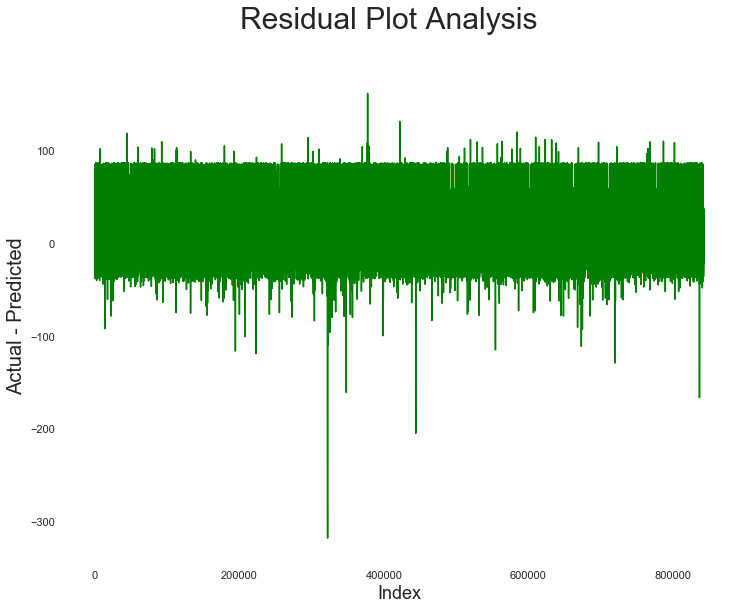

In [148]:
# Error terms
c = [i for i in range(len(Age_prediction_lin1))]
plt.rcParams["axes.grid"] = False
fig = plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
plt.plot(c,y_test-Age_prediction_lin1, color="green", linewidth=1.5, linestyle="-")
fig.suptitle('Residual Plot Analysis', fontsize=30)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Actual - Predicted', fontsize=20) # Y-label
ax.set_facecolor('W')
plt.show()
ax.figure.savefig('C:/Users/YogeshGovindan/Desktop/AVNET/Model/Model_Image/Error_plot_AR.png', bbox_inches='tight', pad_inches=0.0);

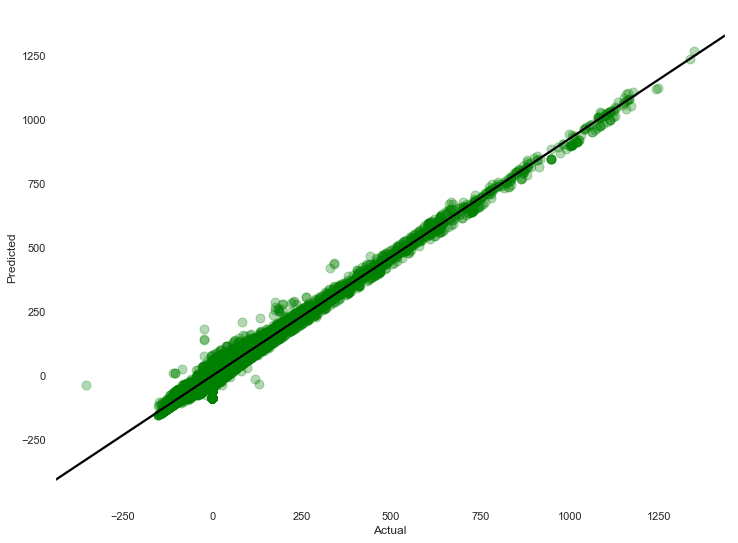

In [146]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': Age_prediction_lin1})
plt.rcParams["axes.grid"] = False
f, ax = plt.subplots(figsize=(12, 9))
sns.regplot(x="Actual", y="Predicted", data=df, ax=ax,scatter_kws={"color": "green",'s':80,"alpha":0.3}, line_kws={"color": "black"});
ax.set_facecolor('w')
ax.figure.savefig('C:/Users/YogeshGovindan/Desktop/AVNET/Model/Model_Image/AR_ActualvsPredicted.png', bbox_inches='tight', pad_inches=0.0)

# Predicting the Open Data set

In [89]:
def diffbucket(predicted):
    if predicted<=(30):
        return "till 30 days"
    elif predicted>(30) and predicted<=45:
        return 'B_31 TO 45 DAYS'
    elif predicted>(45) and predicted<=60:
        return 'C_45 TO 60 DAYS'
    elif predicted>(60) and predicted<=120:
        return 'D_60 TO 120 DAYS'
    else: return 'E_>120 DAYS'

In [90]:
#Predicting on test set
Age_Open_pred_lin=model_lin1.predict(open_data)

In [91]:
#computing MSE and RMSE
lin_mse2=mean_squared_error(open_aging,Age_Open_pred_lin)
lin_remse2=np.sqrt(lin_mse2)
print(lin_remse2)

51.914020882211354


count   270935.00
mean        17.71
std         48.80
min       -285.07
25%         -4.64
50%          0.33
75%         18.03
max       3144.97
Name: AGING, dtype: float64

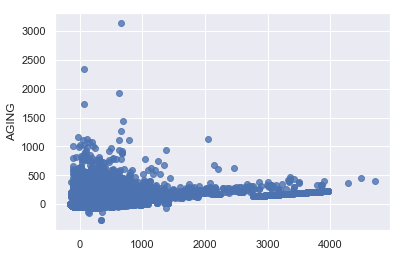

In [92]:
#Regression diagnostics-Residual plot analysis
residuals2=open_aging-Age_Open_pred_lin
sns.regplot(x=Age_Open_pred_lin,y=residuals2,scatter=True,fit_reg=False)
residuals2.describe()

In [93]:
#R squared value
r2_lin_test1=model_lin1.score(open_data,open_aging)

print(r2_lin_test1)

0.9732500003737153


# Concating with the Raw_Open data

In [94]:
open_raw_copy=open_raw_no_disp.copy()

In [95]:
open_raw_copy['DOC_DATE']=pd.to_datetime(open_raw_copy['DOC_DATE'])
open_raw_copy['POSTINGDATE']=pd.to_datetime(open_raw_copy['POSTINGDATE'])
open_raw_copy['NETDUEDATE']=pd.to_datetime(open_raw_copy['NETDUEDATE'])
open_raw_copy['CLEARINGDA']=pd.to_datetime(open_raw_copy['CLEARINGDA'])

In [96]:
#open_raw_copy['NETDUEDATE'] = open_raw_copy['NETDUEDATE'].replace(np.nan, 0)

In [97]:
#open_raw_copy['NETDUEDATE']=pd.to_datetime(open_raw_copy['NETDUEDATE'])

In [98]:
open_raw_copy['NETDUEDATE_year']=pd.DatetimeIndex(open_raw_copy['NETDUEDATE']).year

In [99]:
open_raw_copy['NETDUEDATE_year'].value_counts().sort_index()

2006.00         1
2007.00         1
2008.00         1
2009.00       153
2010.00       225
2011.00       221
2012.00       202
2013.00        29
2014.00        66
2015.00       126
2016.00       687
2017.00      2372
2018.00      7860
2019.00     22754
2020.00    174542
2021.00     61693
Name: NETDUEDATE_year, dtype: int64

In [100]:
open_raw_copy['predicted']=Age_Open_pred_lin

In [101]:
open_raw_copy['open_date']=pd.Timestamp('2020-10-31')

In [102]:
open_raw_copy['predicted1']=np.where(open_raw_copy['predicted']>120,120,open_raw_copy['predicted'])

In [103]:
open_raw_copy['Pred_bucket']=open_raw_copy.apply(lambda x:diffbucket(x['predicted1']),axis=1)

In [104]:
open_raw_copy['Pred_bucket'].value_counts(normalize=True)

till 30 days       0.79
D_60 TO 120 DAYS   0.19
C_45 TO 60 DAYS    0.01
B_31 TO 45 DAYS    0.01
Name: Pred_bucket, dtype: float64

In [105]:
open_raw_copy["Pred_clearing_date"] = pd.to_datetime(open_raw_copy["NETDUEDATE"]) + pd.to_timedelta(open_raw_copy['predicted1'], unit='D')

In [106]:
before_AR_31st_oct=open_raw_copy[open_raw_copy['Pred_clearing_date']<pd.Timestamp('2020-10-31')]

In [107]:
before_AR_31st_oct.shape

(139093, 74)

In [108]:
x=before_AR_31st_oct.shape[0]

In [109]:
y=open_raw_copy.shape[0]

In [110]:
x/y

0.5133814383523724

In [111]:
#open_raw_copy["Pred_clearing_date1"]=np.where(open_raw_copy["Pred_clearing_date"]<open_raw_copy['open_date'],open_raw_copy['open_date']+pd.to_timedelta(-15,unit='D'),open_raw_copy["Pred_clearing_date"])

In [112]:
open_raw_copy["Pred_clearing_date1"]=np.where(open_raw_copy["Pred_clearing_date"]<open_raw_copy['open_date'],open_raw_copy['open_date'],open_raw_copy["Pred_clearing_date"])

In [113]:
open_raw_copy['Pred_clearing_date1']=np.where(open_raw_copy['Pred_clearing_date1'].isnull(),open_raw_copy['open_date'],open_raw_copy['Pred_clearing_date1'])

In [114]:
before_AR_31st_oct_p=open_raw_copy[open_raw_copy['Pred_clearing_date1']<pd.Timestamp('2020-10-31')]

In [115]:
a=before_AR_31st_oct_p.shape[0]
b=open_raw_copy.shape[0]
a/b

0.0

In [116]:
open_raw_copy['Pred_clearing_date_year1']=pd.DatetimeIndex(open_raw_copy['Pred_clearing_date1']).year

In [117]:
open_raw_copy['Pred_clearing_date_year1'].value_counts(normalize=True)

2020   0.77
2021   0.23
Name: Pred_clearing_date_year1, dtype: float64

In [118]:
open_raw_copy['Predicted_month_year'] = pd.to_datetime(open_raw_copy['Pred_clearing_date1']).dt.to_period('M')

In [119]:
open_raw_copy['Predicted_month_year'].value_counts(normalize=True).sort_index()

2020-10   0.52
2020-11   0.14
2020-12   0.11
2021-01   0.06
2021-02   0.03
2021-03   0.06
2021-04   0.04
2021-05   0.03
2021-06   0.01
2021-07   0.00
Freq: M, Name: Predicted_month_year, dtype: float64

In [120]:
open_raw_copy.shape

(270935, 77)

In [121]:
open_raw_copy.columns

Index(['OPEN_INV_NUM', 'NETDUEDATE', 'SYSTEM', 'DOCUMENTNO', 'ITEMNO',
       'FISCALYEAR', 'COMPCODE', 'CUSTOMER', 'CLEARINGDA', 'CLEARINGDOC',
       'ASSIGNMENT', 'POSTINGDATE', 'DOC_DATE', 'CREATEDON', 'CURR',
       'REFERENCEDOCNO', 'DOC_TYPE', 'FISCALPERIOD', 'POSTINGKEY', 'D_CIND',
       'AMOUNT', 'ITEMTXT', 'GLACCOUNT', 'BASELINEDATE', 'PAY_TERM',
       'DIS_DAY1', 'DIS_DAY2', 'NETPAY_TERM', 'DIS_PER1', 'DIS_PER2',
       'DIS_BASE', 'DIS_AMOUNT', 'PAYMETHOD', 'INV_REF', 'INV_REFFISCAL',
       'INV_REFITEM', 'INV_LIST', 'DUNNBLOCK', 'LASTDUNNDATE', 'DUNNLEVEL',
       'DUNNAREA', 'REASONCODE', 'XREF1', 'XREF2', 'PAYREF', 'TCODE',
       'DOCHDR_TXT', 'EXC_RATE', 'GRP_CURR', 'GRP_CURREXCRATE', 'REFTCODE',
       'REFERENCEKEY', 'XREF1HD', 'XREF2HD', 'XREF3', 'VERSION', 'CUST_NAME',
       'RISKCLASS', 'RISKCLASS_DESC', 'DPT_NDPT', 'OVERDUE_FLAG', 'AGING',
       'AGING_BUCKET', 'INT_OR_EXT_COMP', 'ACCNTGROUP', 'ACCOUNTGROUP_DESC',
       'DISPUTE_FLAG', 'AMT_USD', 'NETDUEDAT

# Required column selection and seperating the open data into dispute and non dispute for final prediction

In [122]:
Open_Nondsipute=open_raw_copy.loc[:,['DOCUMENTNO','ITEMNO','Pred_clearing_date1']] #selecing only the required columns from the Non dispute open data

In [123]:
Open_Nondsipute.head()

,DOCUMENTNO,ITEMNO,Pred_clearing_date1
0,9011110108,3,2020-10-31
1,9011133233,10,2020-10-31
2,9011134254,5,2020-10-31
4,9011137413,30,2020-10-31
5,9011118988,64,2020-10-31


In [124]:
Open_Nondsipute.isna().sum()

DOCUMENTNO             0
ITEMNO                 0
Pred_clearing_date1    0
dtype: int64

In [125]:
Open_dispute=open_raw_disp.loc[:,['DOCUMENTNO','ITEMNO']] ## selecing only the required columns from the dispute open data

In [126]:
Open_dispute['Pred_clearing_date1']=pd.Timestamp('2090-10-31') #Note: in dispute data an imaginary date of '2090-10-31' is assigned to maintain the format)

In [127]:
Open_dispute.head()

,DOCUMENTNO,ITEMNO,Pred_clearing_date1
3,9011118913,34,2090-10-31
50,9011133213,10,2090-10-31
101,9011092383,10,2090-10-31
180,9011124000,4,2090-10-31
206,9011056080,7,2090-10-31


# concating both dispute and non dispute 

In [128]:
Predicted_final = pd.concat([Open_Nondsipute, Open_dispute])

In [129]:
Predicted_final['Pred_clearing_date1'] = pd.to_datetime(Predicted_final['Pred_clearing_date1']).dt.date

# Returns the week of the month for the specified date

In [130]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [131]:
Predicted_final['Week_predicted']=Predicted_final.apply(lambda x:week_of_month(x['Pred_clearing_date1']),axis=1)

In [132]:
Predicted_final['DOCUMENTNO']=Predicted_final['DOCUMENTNO'].apply(str)

In [133]:
Predicted_final['ITEMNO']=Predicted_final['ITEMNO'].apply(str)

# Checking the distribution of the predicted date for validation

In [134]:
Predicted_final_test=Predicted_final.copy()

In [135]:
Predicted_final_test['Predicted_month_year'] = pd.to_datetime(Predicted_final_test['Pred_clearing_date1']).dt.to_period('M')

In [136]:
Predicted_final_test['Predicted_month_year'].value_counts(normalize=True).sort_index()

2020-10   0.51
2020-11   0.14
2020-12   0.10
2021-01   0.06
2021-02   0.03
2021-03   0.05
2021-04   0.04
2021-05   0.03
2021-06   0.01
2021-07   0.00
2090-10   0.02
Freq: M, Name: Predicted_month_year, dtype: float64

# Loadin the output to DB

In [137]:
# tuple_of_tuples = tuple([tuple(x) for x in Predicted_final.values])

In [138]:
# load_db2_sql = "INSERT INTO avent.ar_open_prediction_Agg VALUES(?,?,?,?)"
# print(load_db2_sql)

In [139]:
# stmt = ibm_db.prepare(conn, load_db2_sql)

In [140]:
# ibm_db.execute_many(stmt, tuple_of_tuples)

# Joblib###

In [155]:
# import os
# cwd=os.getcwd()

In [156]:
# cwd

'C:\\Users\\YogeshGovindan'

In [157]:
# os.chdir('C:\\Users\\YogeshGovindan\\Desktop\\AVNET\\Model')

In [162]:
# import joblib

In [163]:
# joblib.dump(model_lin1,'nestle_model')

['nestle_model']

In [165]:
# mj=joblib.load('nestle_model')

In [166]:
# Age_prediction_lin3=mj.predict(open_data)

In [167]:
# Age_prediction_lin3

array([-14.95743259, -31.10062401, -16.19675815, ..., -14.32204704,
        11.07555544,  11.07555544])